In [1]:
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import datetime
import psutil
import math
import seaborn as sns
from datetime import timedelta, datetime, tzinfo, timezone, time
from PIL import Image, ImageDraw
from numpy import asarray
from math import atan2,degrees,radians
from scipy.spatial import distance
import sys

In [2]:
def dataPreprocessin(folder,csvNum):
    url = (r'train/'+str(folder)+'/SimpleTest/'+str(csvNum)+'.csv')
    data = pd.read_csv(url)
    if (len(data) <= 2): #check if the file is empty
        return print("CSV file is empty")
    else:
        data.columns = data.columns.str.replace(' ', '')
        data.dropna(inplace=True)
        data['X'] = data.X.astype(float)
        data.Time = data.Time.str.replace("00:","").astype(np.float64)
        return data

>  Notice that file number 22 does not exist (there is only an empty image), we will ignore this file.

In [3]:
data = pd.read_csv(r'train/7554/SimpleTest/5.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   X          505 non-null    object 
 1    Y         503 non-null    float64
 2    Pressure  503 non-null    float64
 3    TiltX     503 non-null    float64
 4    TiltY     503 non-null    float64
 5    Time      503 non-null    object 
dtypes: float64(4), object(2)
memory usage: 23.8+ KB


In [5]:
#remove the extra spaces in the columns.
print(data.columns)
data.columns = data.columns.str.replace(' ', '')
data.head(3)

Index(['X', ' Y', ' Pressure', ' TiltX', ' TiltY', ' Time'], dtype='object')


,X,Y,Pressure,TiltX,TiltY,Time
0,608.351079801363,833.323017,0.107164,-3848.0,-644.0,00:02.7272871
1,608.877699503407,833.165031,0.107164,-3848.0,-644.0,00:02.7429109
2,608.877699503407,833.165031,0.099107,-3848.0,-644.0,00:02.7585749


In [6]:
submit_time = data.iloc[-1][0]
start_time = data.iloc[-2][0]
data.dropna(inplace=True)
print(start_time)
print(submit_time)

total_time = float(submit_time[37:]) - float(start_time[38:])
print("Total time drawing: 00:" +str(total_time))

Time Elapsed till drawing started: 00:02.7272871
Time Elapsed till drawing submit: 00:18.2575765
Total time drawing: 00:15.5302894


In [7]:
data['X'] = data.X.astype(float)

# change the Time column to float
data.Time = data.Time.str.replace("00:","").astype(np.float64)

```python
# other way to deal with the Time column
data.Time = data.Time.apply(lambda x: datetime.strptime(x[:-1],"%M:%S.%f"))
```

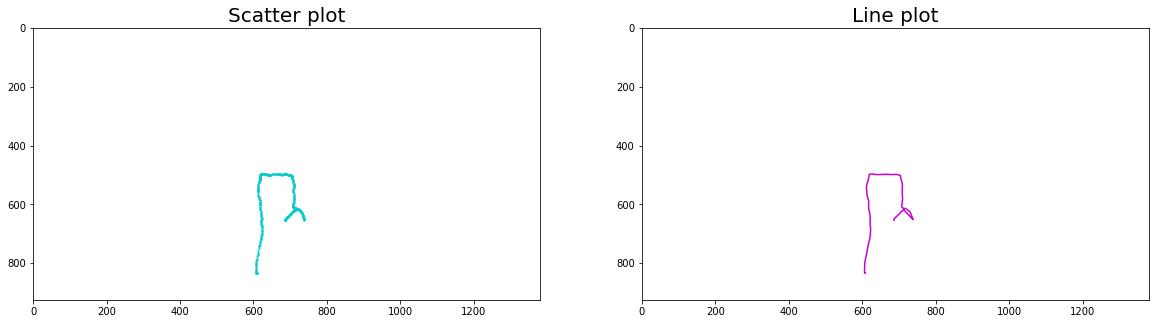

In [8]:
fig=plt.figure(figsize=(20,5))
ax= fig.add_subplot(1, 2, 1)

plt.gca().invert_yaxis()
ax.scatter(data.X,data.Y,s=1,c='#00CCCC')
ax.set_xbound(lower=0.0, upper=1381)
ax.set_ybound(lower=0.0, upper=925)
ax.set_title("Scatter plot",fontdict={'fontsize': 20})

ax2 = fig.add_subplot(1, 2, 2)
plt.gca().invert_yaxis()
ax2.plot(data.X,data.Y,"#CC00CC")
ax2.set_xbound(lower=0.0, upper=1381)
ax2.set_ybound(lower=0.0, upper=925)
ax2.set_title("Line plot",fontdict={'fontsize': 20})

plt.show()

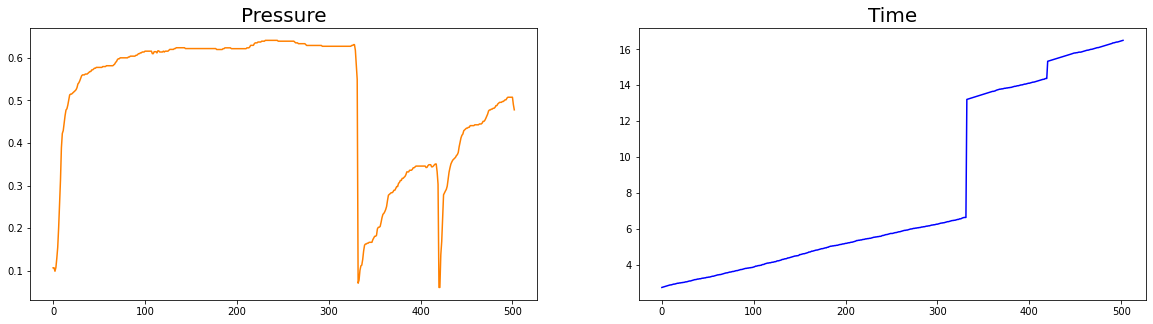

In [9]:
fig=plt.figure(figsize=(20,5))

ax= fig.add_subplot(1, 2, 1)
ax.plot(data.Pressure,"#FF8000")
ax.set_title("Pressure",fontdict={'fontsize': 20})

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(data.Time,c='b')
ax2.set_title("Time",fontdict={'fontsize': 20})

plt.show()

In [210]:
def LiveDarwing(folder,csvNum):
    data = dataPreprocessin(folder,csvNum)
    %matplotlib notebook

    fig = plt.figure(figsize=(5,3))#,dpi=100)
    ax = fig.add_subplot(1,1,1)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    X=[]
    Y=[]
    for i in range (len(data.X)):
        X.append(data.X[i])
        Y.append(data.Y[i])
        plt.tight_layout()
        ax.plot(X,Y , color='r')
        fig.canvas.draw() 
plt.close()

<IPython.core.display.Javascript object>


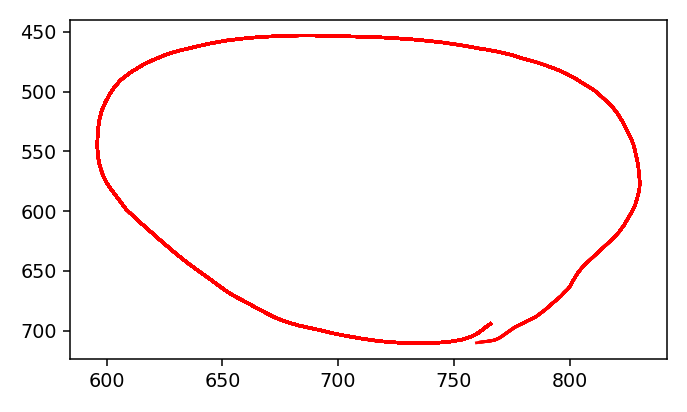

In [211]:
LiveDarwing(7554,3)

## *Hand lifts:*

In [10]:
def handLifts(folder,cvsNum):
    data = dataPreprocessin(folder,cvsNum)
    hand_lifts = 0
    rolling_std = data.Time.rolling(window=14).std()
    index = [0]

    for i in range(len(data.Time)-1):
        if (data.Time[i+1] > data.Time[i] + rolling_std[i]):
            hand_lifts +=1
    print("Number of hand lifts: " + str(hand_lifts))

In [11]:
handLifts(7554,5)

Number of hand lifts: 2


## *Number of lines:*

In [193]:
def find_slope(X2,X1,Y2,Y1):
    slope = (float)(Y2-Y1)/(X2-X1)
    return slope

In [194]:
slopes = [] 
jump = 20
for i in range(0,len(data)-20,40):
    if (data.X[i+20] - data.X[i] == 0):
        continue
    else:
    slopes.append(find_slope(data.X[i+jump], data.X[i], data.Y[i+jump],data.Y[i]))       

slopes = pd.Series(slopes)

In [195]:
numOfLines = 0
roll_std = slopes.rolling(window = 3).std()

for i in range(0,len(slopes)-1):
    if (abs(slopes[i+1] - slopes[i]) < 1) :
        continue
    elif (slopes [i+1] - roll_std[i] > slopes[i]) or (slopes[i] - roll_std[i] > slopes[i+1]):
        numOfLines = numOfLines + 1
        
if numOfLines == 0:
    numOfLines += 1

print("Number of lines: " + str(numOfLines))

Number of lines: 4


In [165]:
def calculateAngle(X1,X0,Y1,Y0):
    deltaX = (X1 - X0)
    deltaY = (Y1 - Y0)
    angle = (math.atan2(deltaY,deltaX))*(180/math.pi)
    if angle < 0:
        angle = 360 + angle
    return angle

In [171]:
angels = []
jump = int(len(data)/10)

for i in range(0,len(data.X)-jump):
    angels.append(calculateAngle(data.X[i+jump],data.X[i],data.Y[i+jump],data.Y[i]))
angels = pd.Series(angels)

In [196]:
numOfLines = 0
roll_std = angels.rolling(window = 35).std()

for i in range(0,len(angels)-1):
    if (abs(angels[i+1] - angels[i]) < 1) :
        continue
    elif (angels [i+1] - roll_std[i] > angels[i]) or (angels[i] - roll_std[i] > angels[i+1]):
        numOfLines = numOfLines + 1
        
if numOfLines == 0:
    numOfLines += 1    

print("Number of lines: " + str(numOfLines))

Number of lines: 6


In [197]:
epsilon = sys.float_info.epsilon
index = [*range (0,len(data),int(len(data)/5))] 

first = (data.X[0],data.Y[0])
last = (data.X[index[-1]],data.Y[index[-1]])

full_distance = math.dist(first,last)

In [200]:
def calculateDist(i):
    sum = 0
    for j in range(index[i],index[i+1]):
        first = (data.X[j],data.Y[j])
        last = (data.X[j+1],data.Y[j+1])
        sum += math.dist(first,last)
    return sum 

In [201]:
count = 0
for i in range(len(index)-1):
    distance =  calculateDist(i)
    if(full_distance - distance < epsilon):
        count += 1
print(count)

1


X = data.X.groupby(np.arange(len(data.X))//20).mean()

Y = data.Y.groupby(np.arange(len(data.Y))//20).mean()

### *Length of the lines:*

In [28]:
def Line_len(X1,Y1,X2,Y2):
    len = math.sqrt((X2-X1)**2 + (Y2-Y1)**2)
    return len

## *Open or closed shape:*
Only relevant for some of the drawings.

(3,4,8,11,13,16,17,19,20,21)

In [46]:
def openOrClose(folder, img_num):
    img = Image.open(r'train/'+str(folder)+'/SimpleTest/'+str(img_num)+'.PNG')
    img = img.convert("RGB")
    img = img.crop((0,220,1360,885))
    target_pixel = (0,0) #Corner of the image
    target_color = (255,255,0) #Yellow
    ImageDraw.floodfill(img,target_pixel,target_color)
    im = asarray(img)
    fig = plt.figure(figsize=(8, 5))  
    plt.imshow(img)
    
    count =0 
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if ((im[i][j] == [255,255,255]).all() == True):
                count+=1
    if count == 0:
        print ("Open Shape")
    else: 
        print ("Close Shape")

Close Shape


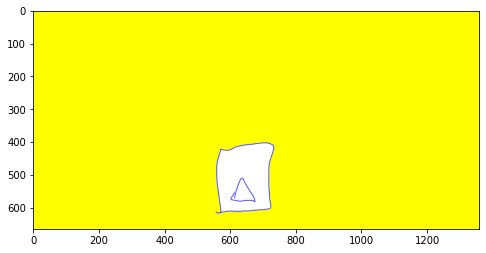

In [47]:
openOrClose(7558, 8)